# Scraping BERUFENET

This scraper collects the ID, name, required competences and salary expectations for all jobs on BERUFENET.

Next to information on jobs the scraper includes study programs and continuing education programs. These can be filtered via category.

The below solution uses Google Chrome and requires the selenium chromedriver. Please adapt the path for the driver accordingly (you can simply save it together with the code).

Mac users with Catalina or above need to enable the chromedriver. To do this open the terminal, navigate to the folder, and run the following command: 

xattr -d com.apple.quarantine chromedriver  

## Libraries

In [1]:
from selenium import webdriver
from string import ascii_uppercase
import requests
import unicodedata
import re
import pandas as pd 
from bs4 import BeautifulSoup as BS
import numpy as np
from collections import Counter
import seaborn as sns

## Functions

In [2]:
# This functions extracts all job IDs from a given html source code

def get_IDs(website):
    
    soup = BS(website)
    main_clean = [soup.select('script[type="text/javascript"]')]
    match = re.findall("'dkzID\\'\:(\d+)",str(main_clean[0][-2]))
    
    return match

In [3]:
# This function collects job competences for one letter (A-Z) based on job IDs

def get_competences(df_IDs,letter):
    
    df_results = pd.DataFrame(columns=['ID','title','category','core_skills','further_skills','letter'])
    
    for i in df_IDs['ID']:
        
        print(i)
        ID = str(i)
        link = "https://berufenet.arbeitsagentur.de/berufenet/faces/index?path=null/sucheAZ/kurzbeschreibung/berufkompetenzen&dkz="+ID+"&let="+letter
        
        # Get the whole page
        page = requests.get(link)    
        soup = BS(page.content, 'html.parser')

        # select relevant elements from page
        title = [tr.get_text() for tr in soup.select('div[class="header-primary-text"]')]
        category = [tr.get_text() for tr in soup.select('div[class="header-secondary-text"]')]
        core_skills = [tr.get_text() for tr in soup.select('ul[id="b20-32_1_Content_1"]')]
        further_skills = [tr.get_text() for tr in soup.select('ul[id="b20-32_2_Content_2"]')]

        # Clean skills
        try:
            core_skills = list(filter(lambda a: a != '', core_skills[0].splitlines()))
        except:
            core_skills = np.nan

        try:
            further_skills = list(filter(lambda a: a != '', further_skills[0].splitlines()))
        except:
            further_skills = np.nan

        # Append results to df_results
        new_row = {'ID':ID, 'title':title[0], 'category':category[0], 'core_skills':core_skills,'further_skills':further_skills, 'letter':letter}
        df_results = df_results.append(new_row, ignore_index=True)
        
    return df_results

In [4]:
# This function collects the salary expectation for jobs starting with one letter (A-Z) based on job IDs

def get_salary(df_IDs,letter):
    
    df_salary = pd.DataFrame(columns=['ID','salary_min','salary_max','letter'])
    
    for i in df_IDs['ID']:
    
        print(i)
        ID = str(i)
        link = "https://berufenet.arbeitsagentur.de/berufenet/faces/index?path=null/sucheAZ/kurzbeschreibung/verdienstmoeglichkeiten&dkz="+ID+"&let="+letter

        # Get the whole page
        page = requests.get(link)    
        soup = BS(page.content, 'html.parser')

        # select relevant elements from page
        salary = [tr.get_text() for tr in soup.select('div[id="b50-0_0_Content_1"]')]

        try:
            salary = re.findall('[0-9]+.[0-9]+',salary[0])

            if len(salary) == 0:
                    salary_min = np.nan
                    salary_max = np.nan

            if len(salary) == 1:
                    salary_min = int(salary[0].replace('.', ''))
                    salary_max = np.nan

            if len(salary) == 2:
                    salary_min = int(salary[0].replace('.', ''))
                    salary_max = int(salary[1].replace('.', ''))

            if len(salary) > 2:
                    print("Problem with the salary")
                    salary_min = "Problem"
                    salary_max = "Problem"

        except:
            salary_min = np.nan
            salary_max = np.nan

        # Append results to df_salary
        new_row = {'ID':ID, 'salary_min':salary_min,'salary_max':salary_max, 'letter':letter}
        df_salary = df_salary.append(new_row, ignore_index=True)

    return df_salary

## Running the Scraper

In [36]:
### Collect all job IDs using Selenium ###

driver = webdriver.Chrome(executable_path='/Users/oleteutloff/Desktop/Scraping_BERUFENET/chromedriver')

# dataframe to store all IDs
df_IDs = pd.DataFrame(columns=['letter','ID'])

for letter in ascii_uppercase:
    
    # to avoid incorrect data collection for X we skip it
    if letter == 'X':
        print('Skipping X')
        continue
    
    url = 'https://berufenet.arbeitsagentur.de/berufenet/faces/index?path=null/sucheAZ&let='+letter
    
    try: 
        driver.get(url)
    except:
        print('Something is wrong with the link')
        continue # jump to the next letter
    
    # collect data of the first page outside of loop to avoid error with letters that have only one page (then there is no 1 to click)
    html = driver.page_source
    df_intermediate = pd.DataFrame(get_IDs(html), columns=['ID'])
    df_intermediate['letter'] = letter
    df_IDs = df_IDs.append(df_intermediate)
    
    # Start clicking from the second page onwoards
    page_number = 2
    
    while True:
        try:
            # get the clickable link with the respective number
            link = driver.find_element_by_link_text(str(page_number))
            # click the link
            link.click()
            # save the source code of this new page
            driver.get(driver.current_url)
            # extract the IDs from the page
            html = driver.page_source
            df_intermediate = pd.DataFrame(get_IDs(html), columns=['ID'])

            df_intermediate['letter'] = letter
            df_IDs = df_IDs.append(df_intermediate)
            
        except:
            print(df_IDs.shape)
            print("End of Letter",letter)
            break
        page_number += 1

driver.close()

(188, 2)
End of Letter A
(563, 2)
End of Letter B
(630, 2)
End of Letter C
(719, 2)
End of Letter D
(834, 2)
End of Letter E
(1288, 2)
End of Letter F
(1463, 2)
End of Letter G
(1600, 2)
End of Letter H
(1824, 2)
End of Letter I
(1849, 2)
End of Letter J
(2093, 2)
End of Letter K
(2227, 2)
End of Letter L
(2471, 2)
End of Letter M
(2515, 2)
End of Letter N
(2562, 2)
End of Letter O
(2754, 2)
End of Letter P
(2760, 2)
End of Letter Q
(2923, 2)
End of Letter R
(3216, 2)
End of Letter S
(3510, 2)
End of Letter T
(3535, 2)
End of Letter U
(3670, 2)
End of Letter V
(3770, 2)
End of Letter W
Skipping X
(3771, 2)
End of Letter Y
(3807, 2)
End of Letter Z


In [6]:
# Exclude wrongly collected X - thre should not be any but to make sure
# For letter X there are no jobs. Accessing this letter makes the browser jump to the default which is letter A. 
# Therefore, the scraper incorrectly collects the IDs of letter A also for letter X. For now, I simply exclude letter X from df_IDs and therefore from the data subsequent data collection.

df_IDs = df_IDs[df_IDs['letter']!='X']

In [7]:
# Check that IDs per letter correspond to website: YES/No? URL for manual comparison: https://berufenet.arbeitsagentur.de/berufenet/faces/index?path=null/sucheAZ&let=A
df_IDs.groupby(['letter']).count()

,ID
letter,
A,188
B,375
C,67
D,89
E,115
F,454
G,175
H,137
I,224


In [41]:
# save IDs
df_IDs.to_csv('/Users/oleteutloff/Desktop/Scraping_BERUFENET/job_IDs.csv', index=False)

In [5]:
# Read in IDs
df_IDs = pd.read_csv('/Users/server/Desktop/Scraping_BERUFENET/job_IDs.csv')

In [8]:
### Get competences ###

# Create dataframe to store the results
df_results = pd.DataFrame(columns=['ID','title','category','core_skills','further_skills','letter'])

for letter in ascii_uppercase:
    
    try: 
        # Get competences for all jobs starting with given letter
        df = get_competences(df_IDs[df_IDs['letter']==letter],letter)
        # Append to the main results dataframe
        df_results = df_results.append(df)

        print('End of letter',letter)
        print(df_results.shape)
        
    except:
        print('There was an exception for letter:',letter)
        continue

94380
93943
8202
10154
4710
10251
14475
15647
132516
59161
94099
94097
133352
59233
94180
94368
94082
90071
93756
94200
58714
100520
59533
30255
29414
94216
93885
93798
94177
93737
93924
93863
93967
9063
9065
14640
94172
94234
100535
15615
13952
51027
5281
94283
94036
58681
93860
94360
14509
27308
14324
6773
29047
15164
2968
59169
7754
7070
58682
27476
14991
59171
94355
94297
9131
94382
59173
128340
130772
13982
5215
14801
9765
67308
6006
9791
58573
94306
94213
15706
93960
94016
58685
93604
94174
28504
7024
7023
34754
5291
58709
90902
8945
4303
15018
27268
28630
14616
27411
9996
67663
7850
7848
7743
7798
8564
67112
14532
7020
15011
27458
15424
28863
27350
14497
111614
34928
15014
14763
8702
8634
93929
59535
9599
8782
10181
120098
120099
8526
59038
15462
27427
820
821
822
819
8517
130025
27385
14338
93766
93993
2634
2635
2631
2630
2636
7085
77111
132718
132717
132719
132721
132723
132724
126840
4003
9673
27469
9634
9152
6093
14645
6727
7172
6876
6728
14050
14198
77951
93864
93755
59039


In [9]:
# save intermediate results
df_results.to_csv('/Users/server/Desktop/Scraping_BERUFENET/df_results.csv', index=False)

In [10]:
### Get salary expectations ###

# Create dataframe to store the results
df_salary = pd.DataFrame(columns=['ID','salary_min','salary_max','letter'])

for letter in ascii_uppercase:
    
    try:
        # Get competences for all jobs starting with given letter
        df = get_salary(df_IDs[df_IDs['letter']==letter],letter)

        # Append to the main results dataframe
        df_salary = df_salary.append(df)

        print('End of letter',letter)
        print(df_salary.shape)
        
    except:
        print('There was an exception for letter:',letter)
        continue

94380
93943
8202
10154
4710
10251
14475
15647
132516
59161
94099
94097
133352
59233
94180
94368
94082
90071
93756
94200
58714
100520
59533
30255
29414
94216
93885
93798
94177
93737
93924
93863
93967
9063
9065
14640
94172
94234
100535
15615
13952
51027
5281
94283
94036
58681
93860
94360
14509
27308
14324
6773
29047
15164
2968
59169
7754
7070
58682
27476
14991
59171
94355
94297
9131
94382
59173
128340
130772
13982
5215
14801
9765
67308
6006
9791
58573
94306
94213
15706
93960
94016
58685
93604
94174
28504
7024
7023
34754
5291
58709
90902
8945
4303
15018
27268
28630
14616
27411
9996
67663
7850
7848
7743
7798
8564
67112
14532
7020
15011
27458
15424
28863
27350
14497
111614
34928
15014
14763
8702
8634
93929
59535
9599
8782
10181
120098
120099
8526
59038
15462
27427
820
821
822
819
8517
130025
27385
14338
93766
93993
2634
2635
2631
2630
2636
7085
77111
132718
132717
132719
132721
132723
132724
126840
4003
9673
27469
9634
9152
6093
14645
6727
7172
6876
6728
14050
14198
77951
93864
93755
59039


In [11]:
# save intermediate results
df_salary.to_csv('/Users/server/Desktop/Scraping_BERUFENET/df_salary.csv', index=False)

### Checking data

In [13]:
# Load data
df_salary = pd.read_csv('/Users/oleteutloff/Desktop/Scraping_BERUFENET/df_salary.csv')
df_results = pd.read_csv('/Users/oleteutloff/Desktop/Scraping_BERUFENET/df_results.csv')

In [5]:
# Check that IDs per letter correspond to website: YES/No - Make sure df_IDs is correct and the use it for comparison
df_results.groupby(['letter']).count()

,ID,title,category,core_skills,further_skills
letter,,,,,
A,188,188,188,142,142
B,375,375,375,323,323
C,67,67,67,50,50
D,89,89,89,68,68
E,115,115,115,91,91
F,454,454,454,370,370
G,175,175,175,137,137
H,137,137,137,118,94
I,224,224,224,179,179


In [6]:
# Check that IDs per letter correspond to website: Yes/No - Make sure df_IDs is correct and the use it for comparison
df_salary.groupby(['letter']).count()

,ID,salary_min,salary_max
letter,,,
A,188,101,86
B,375,190,157
C,67,32,27
D,89,49,44
E,115,72,60
F,454,314,261
G,175,86,71
H,137,71,55
I,224,164,154


In [14]:
# exclude observations that are studyprograms ('Studienfach')
df_results = df_results[df_results['category']!='Studienfach']

In [18]:
# How many jobs with skill information?
df_results['core_skills'].dropna().shape

(2987,)

In [19]:
# count remaining NAs in core skills
df_results['core_skills'].value_counts(dropna=False)

NaN                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        98
['Berichtswesen, Information', 'Betriebswirtschaftslehre', 'Buchführung, Buchhaltung', 'Controlling', 'Finanzplanung', 'Kalkulation', 'Kosten- und Leistungsrechnung', 'Revision']                                                                                                                                                                                                                                                                                        

In [37]:
# How many jobs with salary information
df_results['salary_min'].dropna().shape

(2173,)

In [34]:
### Combine results and write to csv ###

# Merging results
df_results = pd.merge(df_results,df_salary,on=['ID','letter'],how='left')

# writing to json - ADAPT THE PATH according to your needs - json to preserve the list format of the skill columns
df_results.to_json('/Users/oleteutloff/Desktop/Scraping_BERUFENET/results_berufenet.json')

# Data Exploration

In [2]:
df_results = pd.read_json('/Users/oleteutloff/Desktop/Scraping_BERUFENET/results_berufenet.json')

### Extracting and Counting Skills

In [80]:
# Collect all unique skills in a list

def unique_skills(df,skill):
    
    list_of_skills = []

    for index, row in df[skill].iteritems():

        if  isinstance(row,list):

            for skill in row:
                if skill not in list_of_skills:
                    list_of_skills.append(skill)
                    #print("success", skill, len(list_of_skills))
                else:
                    pass

        if  isinstance(row,str):

            if row not in list_of_skills:
                    list_of_skills.append(row)
                    #print("success", row, len(list_of_skills))
            else:
                    pass
        else:
            #print(row, type(row))
            pass 
    return list_of_skills

In [81]:
skills_list = unique_skills(df_results,'core_skills')

In [83]:
# number of core skills
len(skills_list)

3463

In [84]:
further_skills_list = unique_skills(df_results,'further_skills')

In [86]:
# number of further skills
len(further_skills_list)

3864

In [89]:
# Count how many times each skill occurs

def skill_count(list_of_skills,df,skills):

    skill_dict = { i : 0 for i in list_of_skills }

    for index, row in df[skills].iteritems():

        if  isinstance(row,list):

            for skill in row:
                skill_dict[skill] += 1

        if  isinstance(row,str):

            skill_dict[row] += 1

        else:
            pass   
    return skill_dict

In [90]:
core_skills_count = skill_count(skills_list,df_results,'core_skills')

In [103]:
further_skills_count = skill_count(further_skills_list,df_results,'further_skills')

In [102]:
# top core skills
Counter(core_skills_count).most_common()

[('Kalkulation', 660),
 ('Betriebsmitteleinsatz planen', 504),
 ('Kundenberatung, -betreuung', 490),
 ('Arbeitsvorbereitung', 368),
 ('Qualitätsprüfung, Qualitätssicherung', 363),
 ('Kosten- und Leistungsrechnung', 243),
 ('Maschinenführung, Anlagenführung, -bedienung', 219),
 ('Betriebswirtschaftslehre', 185),
 ('Entwurf', 164),
 ('Entwicklung', 163),
 ('Wartung, Reparatur, Instandhaltung', 159),
 ('Controlling', 158),
 ('Marketing', 155),
 ('Forschung', 155),
 ('Fertigungstechnik', 140),
 ('Personalwesen', 134),
 ('Patientenbetreuung', 128),
 ('Laborarbeiten, Labortechnik', 120),
 ('Maschineneinrichtung, Anlageneinrichtung', 117),
 ('Didaktik', 115),
 ('Methodik', 112),
 ('Fertigungs-, Auftragssteuerung', 110),
 ('Verkauf', 108),
 ('Abrechnung', 108),
 ('Einkauf, Beschaffung', 107),
 ('Informationstechnik, Computertechnik', 106),
 ('Konstruktion', 97),
 ('Mess-, Steuer-, Regeltechnik (MSR)', 90),
 ('Büro- und Verwaltungsarbeiten', 85),
 ('Warenannahme, Wareneingangskontrolle', 81),
 

In [104]:
# top further skills
Counter(further_skills_count).most_common()

[('Kundenberatung, -betreuung', 673),
 ('Arbeitsvorbereitung', 604),
 ('Kosten- und Leistungsrechnung', 546),
 ('Qualitätsprüfung, Qualitätssicherung', 481),
 ('Wartung, Reparatur, Instandhaltung', 356),
 ('Qualitätsmanagement', 353),
 ('Lehrtätigkeit (Hochschule)', 346),
 ('Kalkulation', 317),
 ('Arbeitsschutz, Unfallverhütung', 271),
 ('Buchführung, Buchhaltung', 266),
 ('Projektmanagement', 262),
 ('Einkauf, Beschaffung', 233),
 ('Gutachter-, Sachverständigentätigkeit', 232),
 ('Marketing', 226),
 ('Personalplanung', 222),
 ('Fachpublikationen erstellen', 204),
 ('Mess-, Steuer-, Regeltechnik (MSR)', 200),
 ('Ausbildereignungsprüfung', 197),
 ('Personalwesen', 195),
 ('Forschung', 192),
 ('Abrechnung', 190),
 ('Verkauf', 187),
 ('Werbung', 184),
 ('Vortragstätigkeit', 180),
 ('Dokumentation (technisch)', 177),
 ('Controlling', 165),
 ('Recherche, Informationsbeschaffung', 160),
 ('Öffentlichkeitsarbeit, Public Relations', 158),
 ('CAD (Computer Aided Design)-Systeme anwenden', 157),

### Salary distribution

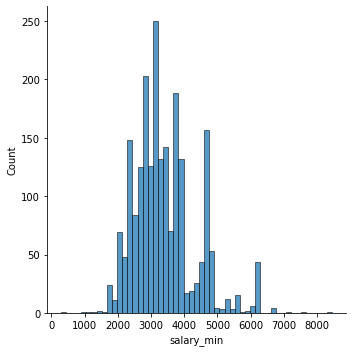

In [8]:
sns.displot(data=df_results[df_results['salary_min']< 9000], x="salary_min")

In [10]:
df_results['salary_min'].mean()

3404.2374597330877